In [3]:
#Importing all the required Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.contrib import rnn
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import matplotlib.pylab as plt


# DataLoading and pre-processing:

Functions defined for Data Loading and Data Pre-processing

DataLoading - Loads the csv data into the system

DataPreprocessing - Performs below operations on the loaded dataset
                    
                    1) Dropping the Duplicates
                   
                    2) Dividing the dataset into features set and the labels set
                    
                    3) Converting catergoial data into numerical data
                    
                    4) Encoding the normal as '1' and abnormal as '0'
                    
                    5) converting input data into float which is requried in the future stage of building 
                        in the network
                    
                    6) Adding another column to the labels set - kind of one hot encoding
                    
                        i.e normal = '1' is represented as '1 0'
                    
                        abnormal = '0' is represented as '0 1'
                    
                        This is required so that the softmax entropy function can efficiently
                        calculate the accuracy.


In [4]:
def DataLoading (mypath):
    print ("Loading the data")
    dataframe = pd.read_csv(mypath,header = None,engine = 'python',sep=",")
    return dataframe

def DataPreprocessing(mydataframe):
    
    # Dropping the duplicates
    recordcount = len(mydataframe)
    print ("Original number of records in the training dataset before removing duplicates is: " , recordcount)
    mydataframe.drop_duplicates(subset=None, inplace=True)  # Python command to drop duplicates
    newrecordcount = len(mydataframe)
    print ("Number of records in the training dataset after removing the duplicates is :", newrecordcount,"\n")

    #Dropping the labels to a different dataset which is used to train the recurrent neural network classifier
    df_X = mydataframe.drop(mydataframe.columns[41],axis=1,inplace = False)
    df_Y = mydataframe.drop(mydataframe.columns[0:41],axis=1, inplace = False)

    # Convert Categorial data to the numerical data for the efficient classification
    df_X[df_X.columns[1:4]] = df_X[df_X.columns[1:4]].stack().rank(method='dense').unstack()
    
    # Coding the normal as " 1 0" and attack as "0 1"
    df_Y[df_Y[41]!='normal.'] = 0
    df_Y[df_Y[41]=='normal.'] = 1
    #print (labels[41].value_counts())
    
    #converting input data into float which is requried in the future stage of building in the network
    df_X = df_X.loc[:,df_X.columns[0:41]].astype(float)

    # Normal is "1 0" and the abnormal is "0 1"
    df_Y.columns = ["y1"]
    df_Y.loc[:,('y2')] = df_Y['y1'] ==0
    df_Y.loc[:,('y2')] = df_Y['y2'].astype(int)
    

    
    return df_X,df_Y

# Feature Selection:

The below function is for the feature selection. RandomForest Classifier is used to select features with top ranks

RandomforestClassifier: Evaluates the importance of the features and plotting features vs importances
Selecting the features with "higher importance" are relevant for the model performance

In [ ]:
def FeatureSelection(myinputX, myinputY):

    labels = np.array(myinputY).astype(int)
    inputX = np.array(myinputX)
    
    #Random Forest Model
    model = RandomForestClassifier(random_state = 0)
    model.fit(inputX,labels)
    importances = model.feature_importances_
    
    
    #Plotting the Features agains their importance scores
    indices = np.argsort(importances)[::-1]
    std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
    plt.figure(figsize = (10,5))
    plt.title("Feature importances (y-axis) vs Features IDs(x-axis)")
    plt.bar(range(inputX.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
    plt.xticks(range(inputX.shape[1]), indices)
    plt.xlim([-1, inputX.shape[1]])
    plt.show()
    
    # Selecting top featueres which have higher importance values = here we can find "12" features
    #as we can see in the next step
    newX = myinputX.iloc[:,model.feature_importances_.argsort()[::-1][:12]]
   # Converting the X dataframe into tensors
    myX = newX.as_matrix()
    myY = labels

   
    return myX,myY

Loading the data into the system

And applying the data preprocessing and feature selection for the dataset

Divinding into train and test datasets 

Performing the above operations are required before training and testing the model

Laoding the IDS Data
Loading the data
Data Preprocessing of loaded IDS Data
Original number of records in the training dataset before removing duplicates is:  13200
Number of records in the training dataset after removing the duplicates is : 13051 

Performing the Feature Selection on train data set


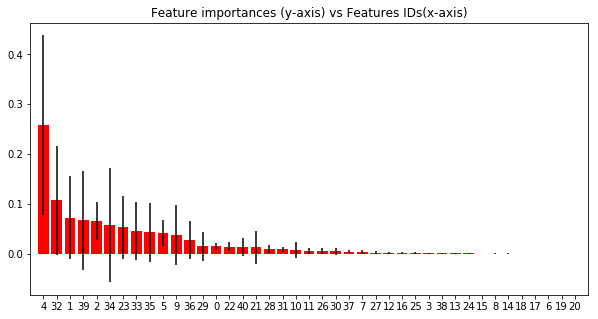

Train X shape is : (8000, 6)
Train Y shape is : (8000, 2)
Test X shape is : (1999, 6)
Test Y shape is : (1999, 2)


In [111]:
print ("Laoding the IDS Data")
data_path = "C:/Users/manp/Documents/IoT/Final/ApplicationLayer/ApplicationLayer.txt"
dataframe = DataLoading(data_path)

print ("Data Preprocessing of loaded IDS Data")
data_X, data_Y = DataPreprocessing(dataframe)

print ("Performing the Feature Selection on train data set")
reduced_X,reduced_Y = FeatureSelection(data_X,data_Y)

#Dividing the dataset into train and test datasets
# Out of 13051 samples = 80% samples as train data and 20% samples as test data

# Train features and Train Labels
train_X = reduced_X[:8000]
train_Y = reduced_Y[:8000]

#Test Features and Test Labels
test_X = reduced_X[8001:10000]
test_Y = reduced_Y[8001:10000]


print ("Train X shape is :", train_X.shape)
print ("Train Y shape is :", train_Y.shape)
print ("Test X shape is :", test_X.shape)
print ("Test Y shape is :", test_Y.shape)

As seen from the above features importance graph, the below features are highly informative

4,32,1,39,2,34,23,33,35,5,9,36

The features are reduced from 40 to 12

# Normalizing the Input Features
Using tensorflow normalizing function

In [112]:
# Before normalizing, the array of input features should be converted to a dataframe
semitrain_X = pd.DataFrame(train_X)
semitest_X = pd.DataFrame(test_X)
#Importing Scikit learn libraries
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#Normalizing Train Data Features
scaler_traindata = scaler.fit(semitrain_X)
train_norm = scaler_traindata.transform(semitrain_X)
train_norm_X = pd.DataFrame(train_norm)

#Normalizing Test Data Features
scaler_testdata = scaler.fit(semitest_X)
test_norm = scaler_testdata.transform(semitest_X)
test_norm_X = pd.DataFrame(test_norm)


# Hyper Paramteres and Placeholders

In [113]:
#Define Hyper Parameters for the model
learning_rate = 0.001
n_classes = 2
display_step = 100
input_features = train_X.shape[1] #No of selected features(columns)
training_cycles = 1000
time_steps = 5 # No of time-steps to backpropogate
hidden_units = 50 #No of LSTM units in a LSTM Hidden Layer

Input Placeholders takes the inputs for the model in the shape [inputs_size,input_features]

Here we are not restricting the input size, therefore it batch_size is given as "None"

Weights and biases are initialized in random using tf.random_normal function

Sizes are defined appropritately as per the logic.

The biases output either '1 0' or '0 1'

In [114]:
#Input Placeholders
with tf.name_scope('input'):
    x = tf.placeholder(tf.float64,shape = [None,time_steps,input_features], name = "x-input")
    y = tf.placeholder(tf.float64, shape = [None,n_classes],name = "y-input")
#Weights and Biases
with tf.name_scope("weights"):
    W = tf.Variable(tf.random_normal([hidden_units,n_classes]),name = "layer-weights")

with tf.name_scope("biases"):
    b = tf.Variable(tf.random_normal([n_classes]),name = "unit-biases")


![title](C:/Users/manp/Desktop/Capture.PNG)

The above image is a sample diagram portraying the back propogation.
In our model,
the Input is a 3D-Tensor of size (Batch_Size,Time_Steps,Num_Features)
Only One hidden layer is used to design a lightweight model - Hidden Layer Size (LSTM Units = 10)
Weights Size (Hidden_units,Num_Classes)
Biases Size (Num_Classes)

Before bulding the model, we have to reshape the inputs in to 3D tensors of size (Batch_Size,time_steps,input_features)
from 2D tensors of size (Batch_Size,input_features). As seen in the above placeholder description, it accepts 
3D inputs.

This can be done as seen below.

In [115]:
#Modify data with respect to the time steps count
def rnn_data(data, time_steps, labels=False):
    """
    creates new data frame based on previous observation
      * example:
        l = [1, 2, 3, 4, 5]
        time_steps = 2
        -> labels == False [[1, 2], [2, 3], [3, 4]]
        -> labels == True [3, 4, 5]
    """
    rnn_df = []
    for i in range(len(data) - time_steps):
        if labels:
            try:
                rnn_df.append(data.iloc[i + time_steps].as_matrix())
            except AttributeError:
                rnn_df.append(data.iloc[i + time_steps])
        else:
            data_ = data.iloc[i: i + time_steps].as_matrix()
            rnn_df.append(data_ if len(data_.shape) > 1 else [[i] for i in data_])

    return np.array(rnn_df, dtype=np.float32)

# Modifications to train data
train_data_X = pd.DataFrame(train_norm_X)
train_data_Y = pd.DataFrame(train_Y)
newtrain_X = rnn_data(train_data_X,time_steps,labels = False)
newtrain_Y = rnn_data(train_data_Y,time_steps,labels = True)

print ("Shape of new train X",newtrain_X.shape)
print ("Shape of new train Y",newtrain_Y.shape)

# Modifications to test data
test_data_X = pd.DataFrame(test_norm_X)
test_data_Y = pd.DataFrame(test_Y)
newtest_X = rnn_data(test_data_X,time_steps,labels = False)
newtest_Y = rnn_data(test_data_Y,time_steps,labels = True)

print ("Shape of new test X",newtest_X.shape)
print ("Shape of new test Y",newtest_Y.shape)

Shape of new train X (7995, 5, 6)
Shape of new train Y (7995, 2)
Shape of new test X (1994, 5, 6)
Shape of new test Y (1994, 2)


# Building the Model

In [116]:
#Unstacking the inputs with time steps to provide the inputs in sequence
# Unstack to get a list of 'time_steps' tensors of shape (batch_size, input_features)
x_ = tf.unstack(x,time_steps,axis =1)

#Defining a single GRU cell
gru_cell = tf.contrib.rnn.GRUCell(hidden_units)

#GRU Output
with tf.variable_scope('MyGRUCel36'):
    gruoutputs,grustates = tf.contrib.rnn.static_rnn(gru_cell,x_,dtype=tf.float64)
    
#Linear Activation , using gru inner loop last output
output =  tf.add(tf.matmul(gruoutputs[-1],tf.cast(W,tf.float64)),tf.cast(b,tf.float64))


We can specify a loss function just as easily. 
Loss indicates how bad the model's prediction was on a single example; 
we try to minimize that while training across all the examples. 
Here, our loss function is the cross-entropy between the target 
and the softmax activation function applied to the model's prediction.

Note that tf.nn.softmax_cross_entropy_with_logits internally applies the softmax on the model's 
unnormalized model prediction and sums across 
all classes, and tf.reduce_mean takes the average over these sums.

In [117]:
#Defining the loss function
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits = output))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)


The tf.train.AdamOptimizer uses Kingma and Ba's Adam algorithm to control the learning rate. 
Adam offers several advantages over the simple tf.train.GradientDescentOptimizer. 
Foremost is that it uses moving averages of the parameters (momentum)

A simple tf.train.GradientDescentOptimizer could equally be used in your model, but would require more hyperparameter 
tuning before it would converge as quickly.

# Model Training

In [118]:
#Training the Model
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in range (training_cycles):
    _,c = sess.run([optimizer,cost], feed_dict = {x:newtrain_X, y:newtrain_Y})
    
    if (i) % display_step == 0:
        print ("Cost for the training cycle : ",i," : is : ",sess.run(cost, feed_dict ={x :newtrain_X,y:newtrain_Y}))
correct = tf.equal(tf.argmax(output, 1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
print('Accuracy on the overall test set is :',accuracy.eval({x:newtest_X, y:newtest_Y}))

Cost for the training cycle :  0  : is :  1.49658893849
Cost for the training cycle :  100  : is :  0.693460223534
Cost for the training cycle :  200  : is :  0.689997076673
Cost for the training cycle :  300  : is :  0.688120609282
Cost for the training cycle :  400  : is :  0.687008004355
Cost for the training cycle :  500  : is :  0.686129875029
Cost for the training cycle :  600  : is :  0.685329069629
Cost for the training cycle :  700  : is :  0.68456846978
Cost for the training cycle :  800  : is :  0.683825161497
Cost for the training cycle :  900  : is :  0.683055802148
Accuracy on the overall test set is : 0.535105


# Evaluation Metrics

confusion matrix 
 [[13  8]
 [11  3]]


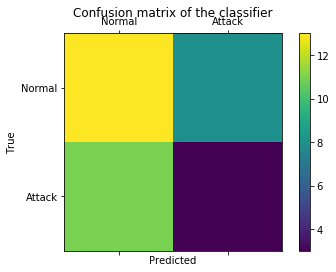

In [107]:
# tf.argmax = Returns the index with the largest value across axes of a tensor.
# Therefore, we are extracting the final labels => '1 0' = '1' = Normal (and vice versa)
# Steps to calculate the confusion matrix

pred_class = sess.run(tf.argmax(output,1),feed_dict = {x:newtest_X,y:newtest_Y})
labels_class = sess.run(tf.argmax(y,1),feed_dict = {x:newtest_X,y:newtest_Y})
conf = tf.contrib.metrics.confusion_matrix(labels_class,pred_class,dtype = tf.int32)
ConfM = sess.run(conf, feed_dict={x:newtest_X,y:newtest_Y})
print ("confusion matrix \n",ConfM)

#Plotting the Confusion Matrix
labels = ['Normal', 'Attack']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(ConfM)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [46]:
# Calculating Accuracy through another procedure
n = tf.cast(labels_class,tf.int64)
newaccuracy = tf.contrib.metrics.accuracy(pred_class,n)
print ("accuracy calcualted using tf.contrib", sess.run (newaccuracy, feed_dict = {x:newtest_X,y:newtest_Y}))

#Calculations performed manually for other metrics
TP = conf[0,0]
FN = conf [0,1]
FP = conf[1,0]
TN = conf[1,1]

AccConf = (TP+TN)/(TP+FP+TN+FN)
print ("Accuracy calculated manually through confusion matrix", sess.run (AccConf, feed_dict = {x:newtest_X,y:newtest_Y}))

# Precision
Precision = TP/(TP+FP)
print ("Precision \n",sess.run(Precision,feed_dict ={x:newtest_X,y:newtest_Y}))

#Recall also known as Sensitivity
Recall = TP/(TP+FN)
print ("Recall (DR) - Sensitivity [True Positive Rate]\n", sess.run(Recall,feed_dict={x:newtest_X,y:newtest_Y}))

# Specificity

Specificity = TN/(TN+FP)
print ("Specificity \n", sess.run(Specificity,feed_dict={x:newtest_X,y:newtest_Y}))

#F score
FScore = 2*((Precision*Recall)/(Precision+Recall))
print ("F1 Score is \n",sess.run(FScore,{x:newtest_X,y:newtest_Y}))

#False Alarm Rate
FAR = FP/(FP+TN)
print ("False Alarm Rate also known as False Positive Rate \n",sess.run(FAR,feed_dict ={x:newtest_X,y:newtest_Y}))

#Efficiency
Efficiency = Recall/FAR
print("Efficincy is \n",sess.run(Efficiency,feed_dict = {x:newtest_X,y:newtest_Y}))

accuracy calcualted using tf.contrib 0.632387
Accuracy calculated manually through confusion matrix 0.632386799693
Precision 
 0.320754716981
Recall (DR) - Sensitivity [True Positive Rate]
 0.0369565217391
Specificity 
 0.957295373665
F1 Score is 
 0.0662768031189
False Alarm Rate also known as False Positive Rate 
 0.0427046263345
Efficincy is 
 0.865398550725


ROC Curve - True Positive Rate(y-axis) vs False Positive Rate (x-axis) for different thresholds


ROC describes the discriminative power of a classifier independent of class distribution 
and unequal prediction error costs (false positive and false negative cost).

Metric like accuracy is calculated based on the class distribution of test dataset or cross-validation,
but this ratio may change when you apply the classifier to real life data, because the underlying class 
distribution has been changed or unknown. On the other hand, 
TP rate and FP rate which are used to construct AUC will be not be affected by class distribution shifting.